# **EYE DETECTION**

# **i. Introduction**

- **Name:** Thaliban Allaam Adristo
- **Batch**: HCK - 025

**Objective:** 

The goal is to create a machine learning model with the ability to accurately classify images of human eyes. The model checks whether the eyes are open or closed. This model can serve as a foundational component for real-life applications, such as drowsiness detection systems.

**Data Overview:** 

The dataset used is generated using MRL and Closed Eyes in Wild (CEW) combined with a personal database from the uploader. The data consists of images showing opened and closed eyes that were taken under various conditions, including diverse lighting conditions, distance, and angle. The current version used is the 4th version which contains a total of 4000 images. The data is balanced between opened and closed eyes images with a total 2000 images for each case.

**Dataset Link**: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset/data

**Deployment Link**: https://huggingface.co/spaces/thalibanallaam/EyeDetection

# **ii. Import Libraries**

In [ ]:
# Import Libraries
import numpy as np
import os
import cv2

# Split dataset
import splitfolders

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# **iii. Data Loading**

In this section, we're going to load the data from the directory so that we'll be able to access the data through this notebook.

**Load the images.**

In [2]:
# Define hyperparameters
path = 'data' #Path containing the data/images used
img_size = 64 #Desired image size (in pixels)
batch_size = 32

# Define ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Load image from directory
data = datagen.flow_from_directory(path,    #Source path of the dataset
                                  target_size = (img_size, img_size),   #Size of the loaded image
                                  batch_size=batch_size,    #Batch size
                                  class_mode='binary', #Binary classification (Open/Closed)
                                  shuffle=True) #Shuffles the data

Found 4000 images belonging to 2 classes.


The output above shows that we have successfully detected and are able to access the images in the predetermined path.

**Show the classes of the data.**

In [3]:
# Index of category
data.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

In this project, "closed eyes" will be represented as "0". Meanwhile, "open eyes" is represented as "1".

# **iv. Exploratory Data Analysis**

In this section, we're going to explore the dataset to get a better understanding of the data that we will be using.

## **a. Data Distribution**

**Counting the amount of data from each class.**

In [4]:
# Dataset path
path_closed = "data/Closed_Eyes" #Closed eyes
path_open = "data/Open_Eyes"     #Opened eyes

# Count total images
total_images_1 = len([f for f in os.listdir(path_closed) if f.endswith(('.png', '.jpg', '.jpeg'))])
print(f"Total Closed Eye Images: {total_images_1}")
total_images_2 = len([f for f in os.listdir(path_open) if f.endswith(('.png', '.jpg', '.jpeg'))])
print(f"Total Opened Eye Images: {total_images_2}")


Total Closed Eye Images: 2000
Total Opened Eye Images: 2000


**Visualize with pie chart.**

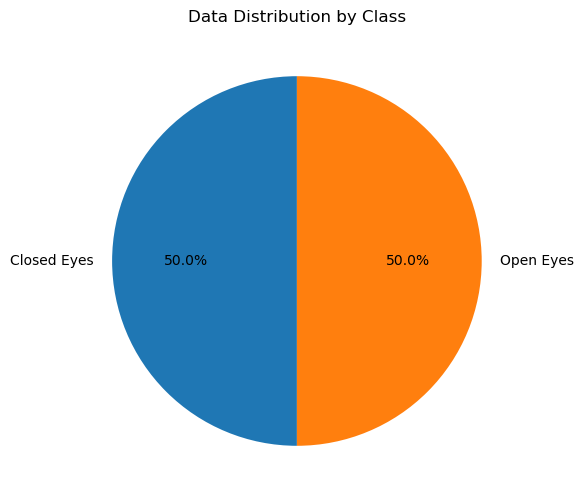

In [5]:
# Define parameters
class_labels = ['Closed Eyes', 'Open Eyes']
class_counts = [total_images_1, total_images_2]

# Create the figure
plt.figure(figsize=(6, 6)) 

# Create the pie chart
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Data Distribution by Class') 
plt.show()

Based on the output above, the data is balanced with a total of 2000 data from each class.

## **b. Data Visualization**

In this section, we're going to show a few samples of the data from the dataset used in this project.

**Show image samples from the dataset.**

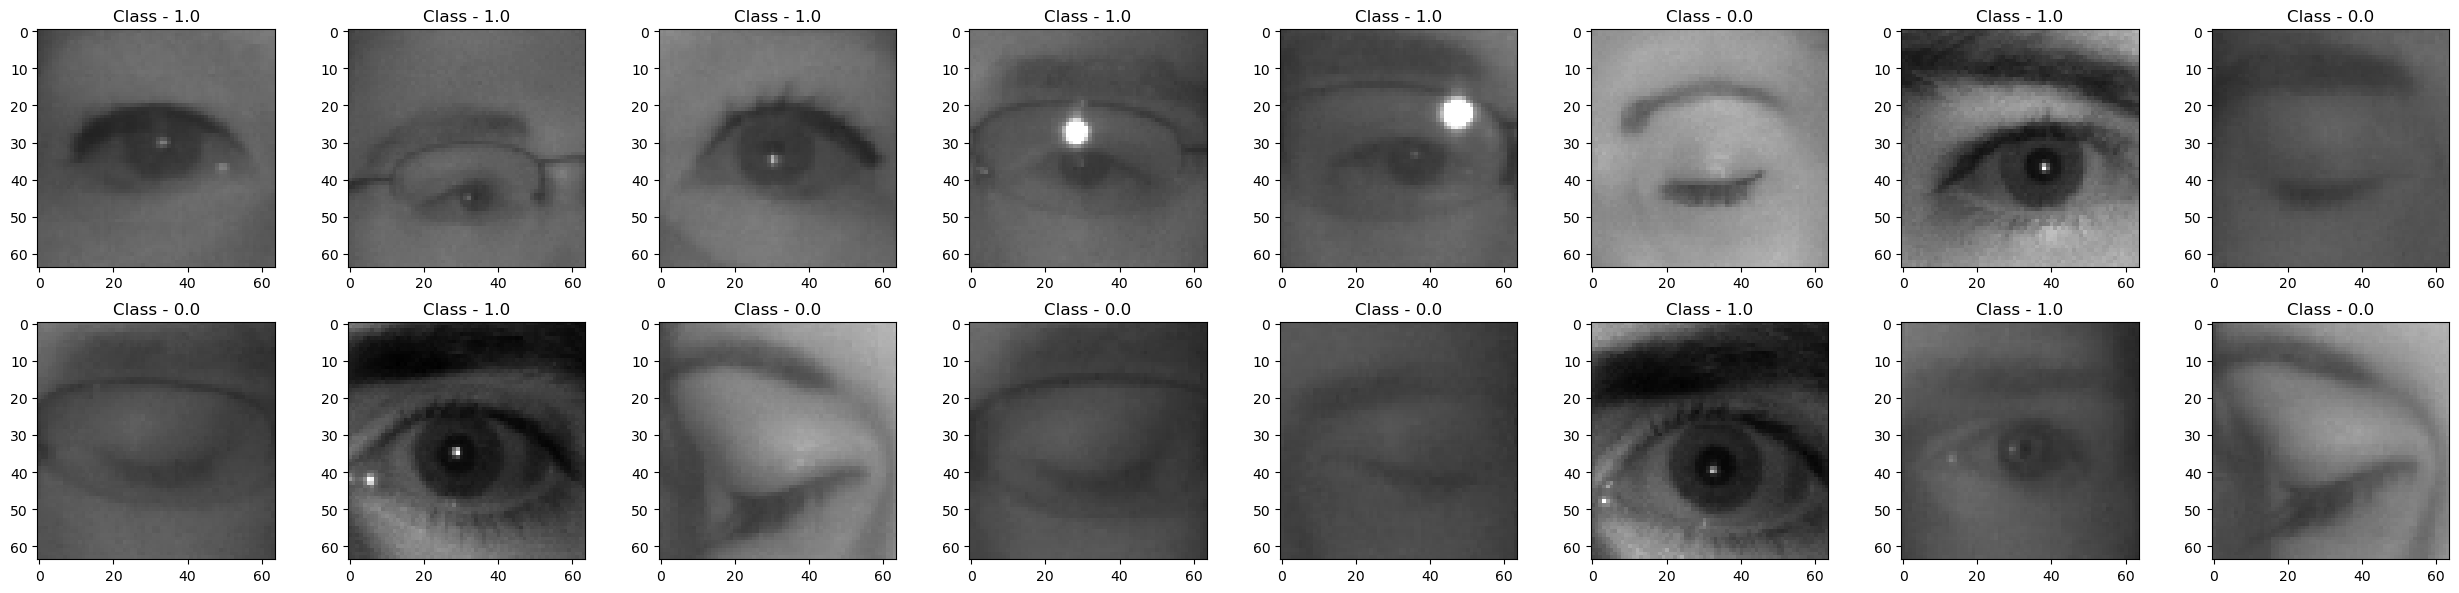

In [6]:
# Create figure
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(25,6))
n = 0

# Loop to extract image data and showing them in the figure
for i in range(2):
  for j in range(8):
    img = data[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(data[0][1][n]))
    n += 1

plt.tight_layout()
plt.show()

Based on the output above, there are two type of images, opened eyes and closed eyes. Opened eyes are represented as "Class - 1.0" whereas closed eyes are "Class - 0.0".

From what we can see, the images varies in lighting condition, angle, distance, and the clarity of the image.

## **c. Image Statistics**

In this section, we're going to analyze the statistics of the data from the dataset.

**Preprocessing**

In [7]:
# Dataset path
path_open = 'data\Open_Eyes'
path_closed = 'data\Closed_Eyes'

# Empty list to store data
image_sizes = []
aspect_ratios = []


'''
Loop to search for images in the directory, read the data, and save them in the empty lists.
'''
# Open eyes
for filename in os.listdir(path_open):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(path_open, filename)
        img = cv2.imread(image_path)
        height, width, _ = img.shape
        image_sizes.append((width, height))
        aspect_ratios.append(width / height)

# Closed eyes
for filename in os.listdir(path_closed):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(path_closed, filename)
        img = cv2.imread(image_path)
        height, width, _ = img.shape
        image_sizes.append((width, height))
        aspect_ratios.append(width / height)


Since we have loaded the image data statistics and saved them in the lists, now we can analyze them even further by querying the data straight from the list.

### **1. Image Size Distribution**

Analyze the size of the images in the dataset, specifically the heights and widths separately.

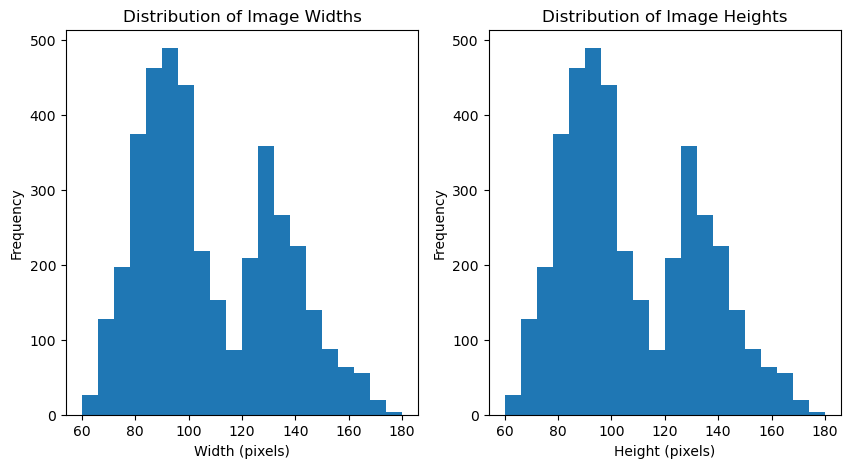

In [8]:
# Parameter
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Create figure
plt.figure(figsize=(10, 5))

# Width plot
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Height plot
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.show()

**Notes:**
- For widths, most images have widths in between the 80 - 100 and 130 - 140 pixels range.
- For heights, most images have heights with the same range (in pixels) as widths.
- Since the range for heights and widths are very similar, it is most likely that the images in the dataset are square shaped.

### **2. Aspect Ratio Distribution**

Analyze the aspect ratio of the images in the dataset.

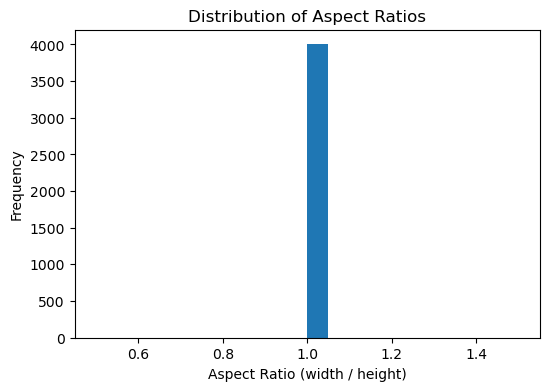

In [9]:
# Create figure
plt.figure(figsize=(6, 4))

# Plot histogram
plt.hist(aspect_ratios, bins=20)
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frequency')

plt.show()

**Notes:**
- All images in the dataset have a 1.0 aspect ratio which means that they are square shaped.
- This result aligns with the image size distribution results that showed a similar distribution between the distribution of widths and heights.

# **v. Feature Engineering**

## **a. Data Splitting**

Since the data in the dataset isn't split yet, we're going to split the data into train, test, and validation sets.

**Split the dataset.**

In [ ]:
# Input folder containing the dataset
input_folder = 'data'  

# Output folder where the train and test folders will be created
output_folder = 'output'

# Split the data into train and test sets (70% train, 20% validation, 10% test)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

Copying files: 4000 files [00:03, 1087.11 files/s]


## **b. Data Preprocessing**

Since the data is already split, we can now load the data to build the model.

The data will be loaded and processed accordingly to accommodate the modeling process.

**Define hyperparameters.**

In [11]:
# Data paths
train_path = 'output/train'
test_path = 'output/test'
val_path = 'output/val'

# Parameters
batch_size = 32
target = (64, 64)
img_height = 64
img_width = 64

**Description:**
- Batch size is set to 32 based on rule of thumb for simple CNN models. Using this batch size gives better generalization to avoid overfitting and is more accommodating for weaker computing, but may result in slower training process for larger datasets.
- Based on EDA, most of the images in the dataset are sized above 80x80 pixels. To make the data more uniform, we will resize the images to 64x64 pixels.

**Data loading and augmentation.**

In [ ]:
# Define ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/.255,
                                width_shift_range=[-10, 10],
                                height_shift_range=[-10, 10],
                                rotation_range=120,
                                zoom_range = [0.3, 1.5],
                                shear_range=10)
test_datagen = ImageDataGenerator(rescale=1/.255)

# Loading the images from the directory 
# Train-set
train_data = train_datagen.flow_from_directory(train_path,
                                                target_size=target,
                                                color_mode='grayscale',
                                                class_mode='binary',
                                                batch_size = batch_size,
                                                shuffle=True,
                                                seed = 2)
# Test-set
test_data = test_datagen.flow_from_directory(test_path,
                                                target_size=target,
                                                color_mode='grayscale',
                                                class_mode='binary',
                                                batch_size = batch_size,
                                                shuffle=False,
                                                seed = 2)
# Validation-set
val_data = train_datagen.flow_from_directory(val_path,
                                                target_size=target,
                                                color_mode='grayscale',
                                                class_mode='binary',
                                                batch_size = batch_size,
                                                shuffle=False,
                                                seed = 2)

Found 2800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


**Notes:**
- The data train-set is shuffled to improve the training results.
- The test and validation data in not shuffled to avoid misalignment during the model evaluation process.

**View the augmented data.**

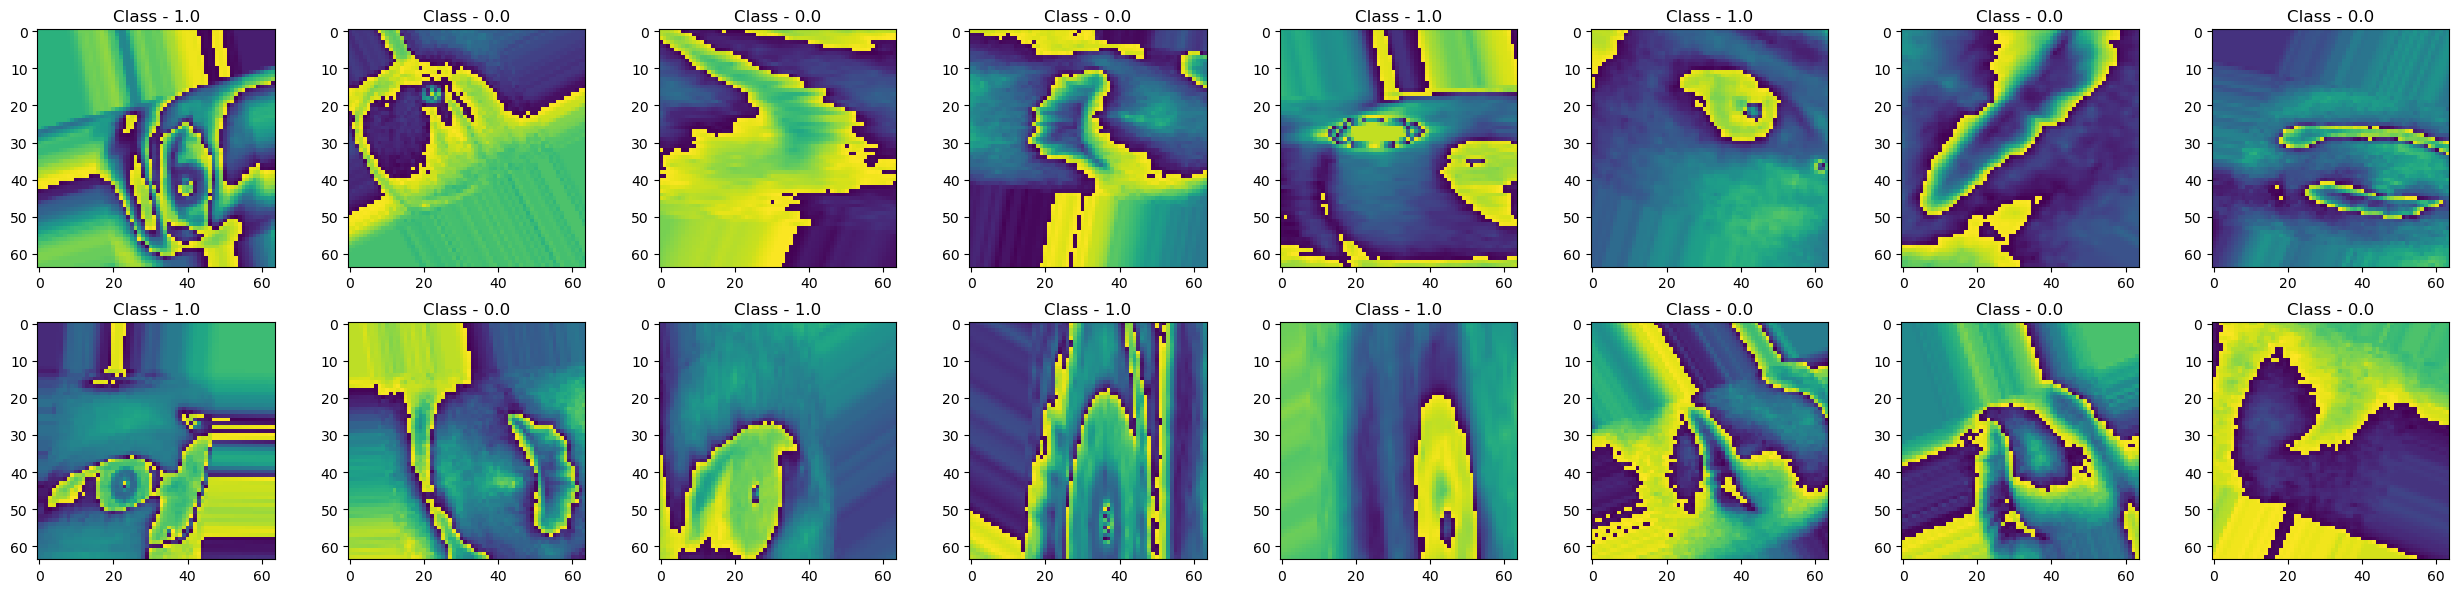

In [13]:
# Show each of image from both categories
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(25,6))
n = 0

for i in range(2):
  for j in range(8):
    img = train_data[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(train_data[0][1][n]))
    n += 1

plt.tight_layout()
plt.show()

The images above are the augmented data that will be used to train the model. Data augmentation helps by adding more variation to the train-set.

# **vi. CNN Training**

## **a. Model Definition**

For the initial model, we're going to try to create a simple CNN model with the most basic architecture. The model will be a **sequential** model consisting the following layers.
- **One convolution layer**: Generate a set of feature maps from the input that represents different features of the input.
- **One pooling layer**: Reduce the spatial dimension of the feature maps generated by the convolution layer.
- **Two feed forward layers**: Process the input until it reaches the last layer that will generate the final prediction.

Since the model that we'll be making is quite simple, using a sequential model should suffice. Using functional model would be overkill and might cause unnecessary problem, such as overfitting.

The reason why we want to be as simple as possible for the initial model is to see the quality of the data and see how far can we go by utilising the most basic model.

For the evaluation metrics, we will focus on **accuracy** to see how many correct predictions can the model make.

**Defining the model.**

In [ ]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Sequential Model
model = tf.keras.models.Sequential()

# Adding layers
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1))) # 1 for grayscale
model.add(tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

**Plot the layers.**

In [15]:
# Plot layers
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## **b. Model Training**

In [16]:
# Define hyperparameters
epoch = 30

# Train the model
history = model.fit(train_data, epochs=epoch, validation_data=val_data)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.5447 - loss: 2.5974 - val_accuracy: 0.7638 - val_loss: 0.5368
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6830 - loss: 0.5784 - val_accuracy: 0.5000 - val_loss: 0.7679
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6674 - loss: 0.6143 - val_accuracy: 0.5000 - val_loss: 0.9342
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6512 - loss: 0.7165 - val_accuracy: 0.7475 - val_loss: 0.4825
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7305 - loss: 0.5014 - val_accuracy: 0.7462 - val_loss: 0.4882
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7459 - loss: 0.4841 - val_accuracy: 0.7188 - val_loss: 0.5333
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7006 - loss: 0.5576 - val_accuracy: 0.7450 - val_loss: 0.5279
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7438 - loss: 0.4916 - val_accuracy: 0.7600 -

## **c. Model Evaluation**

In this section, we're going to evaluate the performance of the model that has been trained in the previous section.

**Plot training results.**

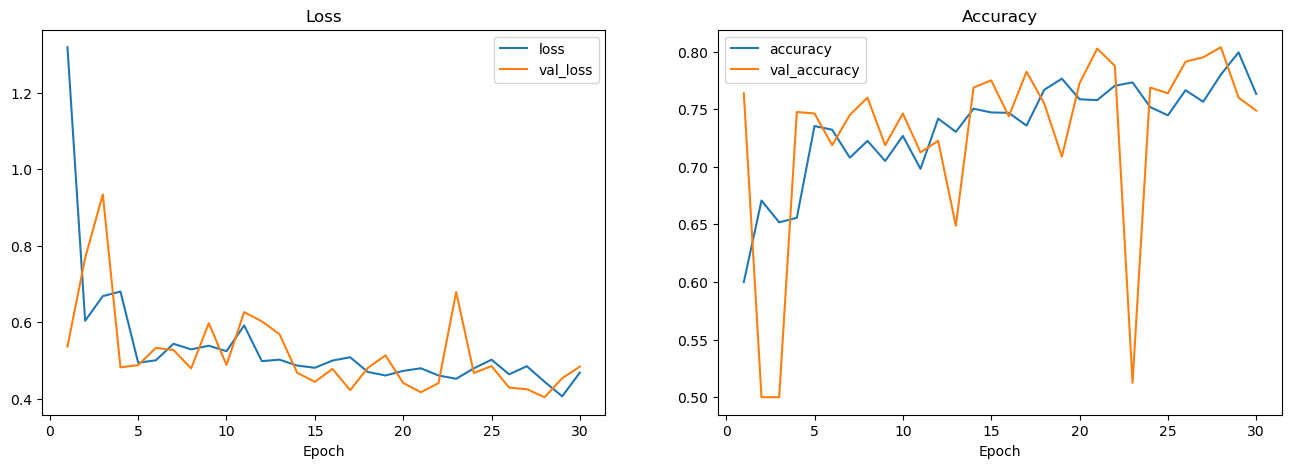

In [17]:
# Plot training results
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1, epoch+1), history.history['loss'], label='loss')
ax[0].plot(range(1, epoch+1), history.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch+1), history.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch+1), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

**Description:**

The plot above shows the training results of the initial model which is represented by a comparison of loss and accuracy recorded during the training process.
- Based on the loss plot, the shape of loss (training loss) and val_loss (validation loss) is very similar with minimum deviation from each other making the model a good fit despite having a couple of fluctuations for certain epochs.
- Based on the accuracy plot, the model's performance isn't very stable since the graph shows that the accuracy level oscillates very frequently.
- Based on the results, the accuracy still need some fixing.

**Get the precise number for accuracy and loss.**

In [18]:
# Evaluate on the training and test sets
loss_base, accuracy_base = model.evaluate(test_data)

# Print results
print(f"Loss: {loss_base:.3f}, Accuracy: {accuracy_base:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.6010 - loss: 0.6783
Loss: 0.493, Accuracy: 0.745


In [19]:
# Get true labels from the test data
y_true = test_data.classes

# Get predicted labels from the model
y_pred = model.predict(test_data)  # Get predicted probabilities
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_data.class_indices)

# Print the report
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

 Closed_Eyes       0.93      0.53      0.68       200
   Open_Eyes       0.67      0.96      0.79       200

    accuracy                           0.74       400
   macro avg       0.80      0.74      0.73       400
weighted avg       0.80      0.74      0.73       400



**Notes:**
- The accuracy between the results of classification report and "evaluate()" method from Tensorflow is aligned.
- Based on the F1-score, between opened and closed eyes., the model is better at predicting open eyes by 11% compared to closed eyes.

**Plot the confusion matrix.**

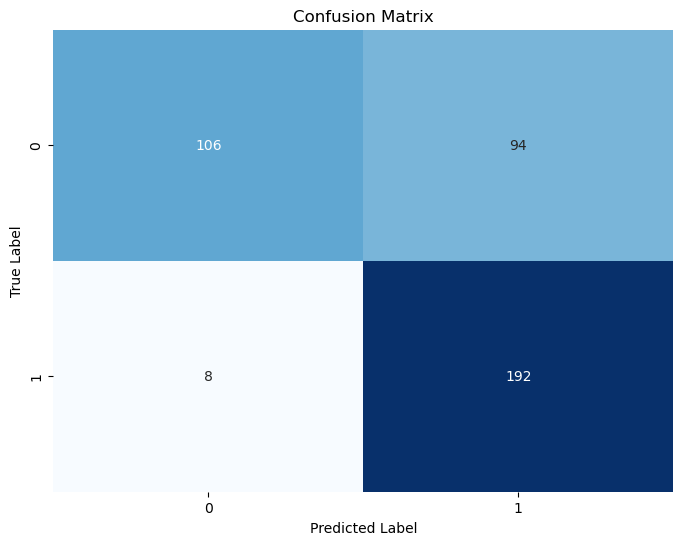

In [20]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Notes:**
- 0 = closed; 1 = open
- Based on the confusion matrix, the model is more likely to confuse closed eyes for open eyes rather than vice versa with 94 wrong predictions compared to 8.

# **vii. CNN Improvement**

For the improvement, we're going to make the model architecture a little bit more complex by adding more layers. The new model will have the following layers.
- **Three convolution layer**: Additional two layers compared to the base model.
- **Three pooling layer**: Additional two layers compared to the base model.
- **One dropout layer**: Regularization to avoid overfitting by deactivating neurons during forward/backward pass of the training process.
- **Two feed forward layers**: No changes made.

We will also use **callback** during the training of the model to improve its training process. Callback allows you to interact with the training process and automate tasks, such as model saving and even stopping the training process under certain conditions.

## **a. Model Definition**

**Defining the model.**

In [21]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Sequential Model
model_new = tf.keras.models.Sequential()

# Adding layers
# Convolution layers
model_new.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
model_new.add(tf.keras.layers.MaxPooling2D(2, 2))

model_new.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model_new.add(tf.keras.layers.MaxPooling2D(2, 2))

model_new.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model_new.add(tf.keras.layers.MaxPooling2D(2, 2))

model_new.add(tf.keras.layers.GlobalAveragePooling2D())

model_new.add(tf.keras.layers.Dropout(0.2))

model_new.add(tf.keras.layers.Dense(256, activation='relu'))
model_new.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model_new.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,953 (492.00 KB)

 Trainable params: 125,953 (492.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Plot layers
tf.keras.utils.plot_model(model_new, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## **b. Model Training**

In [23]:
# Define hyperparameters
epoch = 30
checkpoint = ModelCheckpoint(
    "model_new.keras",  # Filepath to save the model
    monitor="val_accuracy",  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode="max",  # Save the model with the minimum validation loss
    verbose=1
)

# Train the model
history_new = model_new.fit(train_data, epochs=epoch, validation_data=val_data, callbacks=[checkpoint])

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6737 - loss: 2.9112
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to model_new.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6746 - loss: 2.8914 - val_accuracy: 0.7750 - val_loss: 0.4551
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8012 - loss: 0.4170
Epoch 2: val_accuracy improved from 0.77500 to 0.84250, saving model to model_new.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8016 - loss: 0.4165 - val_accuracy: 0.8425 - val_loss: 0.3457
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8624 - loss: 0.3319
Epoch 3: val_accuracy improved from 0.84250 to 0.88875, saving model to model_new.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8625 - loss: 0.3318 - val_accuracy: 0.8888 - val_loss: 0.3035
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8929 - loss: 0.2843
Epoch 4: val_accuracy improved from 0.88875 to 0.91

## **c. Model Evaluation**

In this section, we're going to evaluate the performance of the new model that has been trained in the previous section.

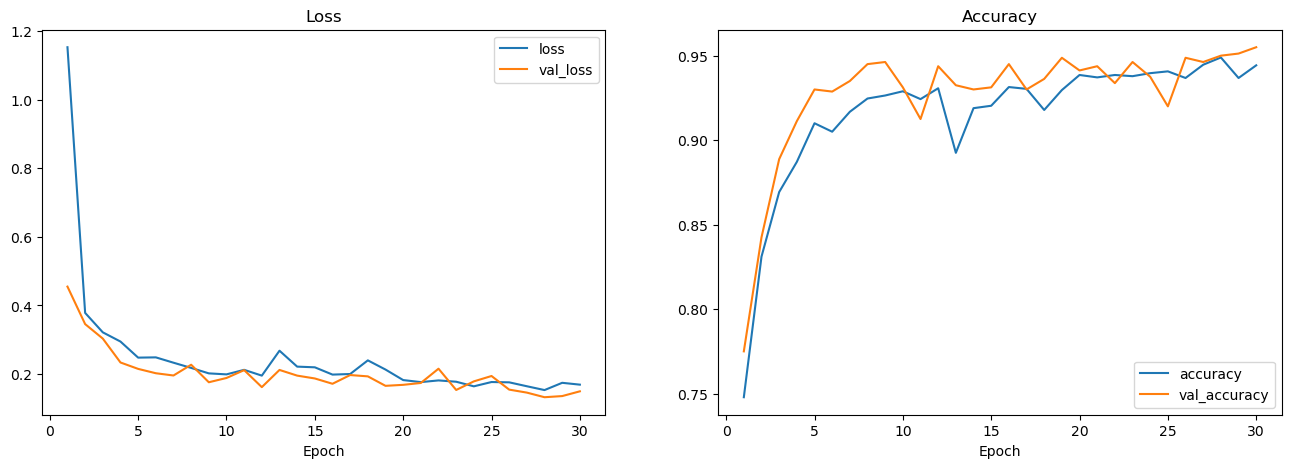

In [24]:
# Plot training results

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1, epoch+1), history_new.history['loss'], label='loss')
ax[0].plot(range(1, epoch+1), history_new.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch+1), history_new.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch+1), history_new.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

**Description:**

The plot above shows the training results of the initial model which is represented by a comparison of loss and accuracy recorded during the training process.
- Based on the loss plot, the graph is very similar to the previous model with minimum deviation from each other making the model a good fit.
- Based on the accuracy plot, the model's performance is now a lot more stable with less oscillations compared to the previous model.

**Get the precise number for accuracy and loss.**

In [25]:
# Load the best model
model_2 = load_model("model_new.keras")

# Evaluate on the training and test sets
loss_2, accuracy_2 = model_2.evaluate(test_data)

# Print results
print(f"Loss: {loss_2:.3f}, Accuracy: {accuracy_2:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9051 - loss: 0.3166
Loss: 0.218, Accuracy: 0.935


In [26]:
# Get true labels from the test data generator
y_true_new = test_data.classes

# Get predicted labels from the model
y_pred_prob_new = model_new.predict(test_data)  # Get predicted probabilities
y_pred_new = (y_pred_prob_new >= 0.5).astype(int)  # Convert probabilities to class labels

# Generate the classification report
report_new = classification_report(y_true_new, y_pred_new, target_names=test_data.class_indices)

# Print the report
print(report_new)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

 Closed_Eyes       0.97      0.90      0.93       200
   Open_Eyes       0.90      0.97      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400



**Notes:**
- The accuracy between the results of **classification report** and **evaluate()** method from Tensorflow is aligned.
- According to the evaluate() method, there is a significant improvement in loss and accuracy compared to the previous model:
    - Loss is reduced from 0.493 to 0.149.
    - Accuracy is improved from 0.745 to 0.957.
- Overall, the new model has improved its performance compared to the previous model.

**Plot the confusion matrix.**

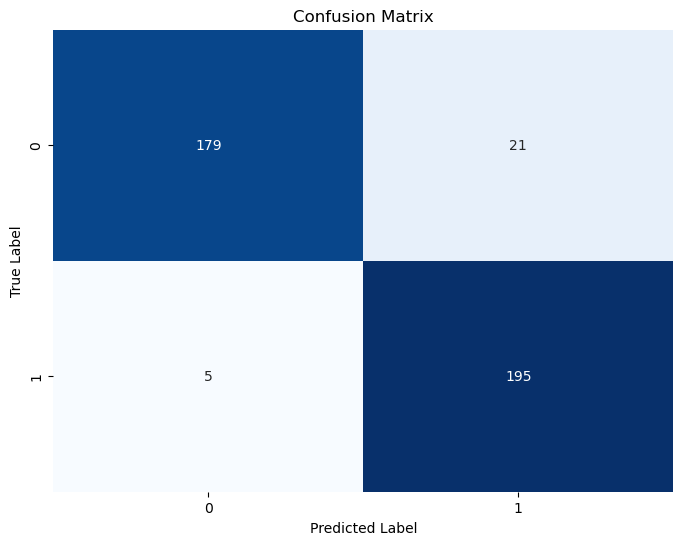

In [27]:
# Create the confusion matrix
cm_new = confusion_matrix(y_true_new, y_pred_new)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Notes:**
- 0 = closed; 1 = open
- The ones with blue square are correct predictions, whereas the rest are wrong predictions.
- Based on the confusion matrix, the model is more likely to confuse closed eyes for open eyes rather than vice versa with 21 wrong predictions compared to 5.
- Since the accuracy has improved, the false predictions has also reduced significantly and that is shown in the confusion matrix.

# **viii. Model Saving**

The model is already saved as `model_new.keras` during the training process through the "**Model Checkpoint**" callback function.

# **ix. Conclusion**

## **a. Objective**

The objective is to create a machine learning model with the ability to predict images of open/closed eyes as a foundation for drowsiness detection system. Through this project, we made two different models consisting of a base model and an improvement model. The changes for the improvement were made on the architecture of the CNN model.

Based on the results, the second model shows significant improvement in performance compared to the base model making it the best model used for the model inference process.

## **b. EDA**

- The data consists a total of 4000 images which are divided by two different classes, open and closes eyes. Each class has 2000 data which makes the dataset balanced.
- The data varies in lighting condition, angle, distance, and the clarity of the image.
- For widths, most images have widths in between the 80 - 100 and 130 - 140 pixels range.
- For heights, most images have heights with the same range (in pixels) as widths.
- Since the range for heights and widths are very similar, it is most likely that the images in the dataset are square shaped.

## **c. Model Evaluation**

### **1. Base Model**

**Training Plot**
- Based on the loss plot, the shape of loss (training loss) and val_loss (validation loss) is very similar with minimum deviation from each other making the model a good fit despite having a couple of fluctuations for certain epochs.
- Based on the accuracy plot, the model's performance isn't very stable since the graph shows that the accuracy level oscillates very frequently.
- Based on the results, the accuracy still need some fixing.

**Classification Report**
- The accuracy between the results of classification report and "evaluate()" method from Tensorflow is aligned.
- Based on the F1-score, between opened and closed eyes., the model is slightly better at predicting closed eyes compared to open. Just slightly better by 11%.

**Confusion Matrix**
- Based on the confusion matrix, the model is more likely to confuse closed eyes for open eyes rather than vice versa with 94 wrong predictions compared to 8.

### **2. Improved Model**

**Training Plot**
- Based on the loss plot, the graph is very similar to the previous model with minimum deviation from each other making the model a good fit.
- Based on the accuracy plot, the model's performance is now a lot more stable with less oscillations compared to the previous model.

**Classification Report**
- The accuracy between the results of classification report and "evaluate()" method from Tensorflow is aligned.
- According to the evaluate() method, there is a significant improvement in loss and accuracy compared to the previous model:
    - Loss is reduced from 0.493 to 0.149.
    - Accuracy is improved from 0.745 to 0.957.
- Overall, the new model has improved its performance compared to the previous model.

**Confusion Matrix**
- Based on the confusion matrix, the model is more likely to confuse closed eyes for open eyes rather than vice versa with 21 wrong predictions compared to 5.
- Since the accuracy has improved, the false predictions has also reduced significantly and that is shown in the confusion matrix.

### **3. Model Improvement**

**Inference Results:**

The inference results show that the model has trouble predicting images outside the dataset. The model architecture isn't the problem since we tried to use the basic model and it gave the same results as well. The preprocessing process is also the same as the one during training. This means that the model is overfit and biased towards the training dataset. The following are possible reasons why this happened.
- The resolution of the data is too low.
- The data used for training is in grayscale which means less variety.
- The amount of data is insufficient to create a proper model.

Overall, the main cause is the lack of quality and variety in the dataset which led to suboptimal training process.

**Improvement:**

We can do the following things to improve the current model.
- Find data with higher resolution.
- Find data with colored images.
- Find dataset with more data.

The new dataset will then be used to train the current model to improve its performance.